In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../traces/MSR-Cambridge/hm_0.csv', header=None)
df.columns = ['Timestamp', 'Hostname', 'DiskNumber', 'Type', 'Offset', 'Size', 'ResponseTime']
df['Timestamp'] = df['Timestamp'].astype(np.int64)
df = df.sort_values(by='Timestamp')
df.head()

,Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime
0,128166385295514663,hm,0,Write,9056014336,2048,2833
1,128166385295514878,hm,0,Write,11855351808,512,2617
2,128166385295515175,hm,0,Write,5548077056,4096,2320
3,128166385301451520,hm,0,Write,3163095040,40960,3438
4,128166385301453920,hm,0,Write,3154132992,4096,1037


In [3]:
print(df['Hostname'].value_counts())
print(df['DiskNumber'].value_counts())

hm    3993316
Name: Hostname, dtype: int64
0    3993316
Name: DiskNumber, dtype: int64


In [4]:
total_size = df.drop_duplicates(['Offset'])['Size'].sum()
total_size

5627630592

In [5]:
workload_of_caches = [0, 0, 0, 0]
for row in df.drop_duplicates(['Offset']).itertuples():
    workload_of_caches[(getattr(row, 'Offset') // 10000 % 1000000) & 0b11111 % 4] += 1
workload_of_caches        # 检验哈希函数合理性

[110253, 109662, 109646, 109626]

In [6]:
def make_requests():
    for row in df.itertuples():
        yield getattr(row, 'Offset'), getattr(row, 'Size')

In [7]:
class Server:                                       # 服务器(cache)
    def __init__(self, space):
        self.space = space                          # cache大小
        self.remain = space                         # cache剩余空间
        self.cache = OrderedDict()                  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0                          # 命中次数
        self.bite_hit_count = 0
        self.miss_count = 0                         # 未命中次数
        self.bite_miss_count = 0

    def _hit(self, fid, size):
        self.hit_count += 1
        self.bite_hit_count += size
        self.cache.move_to_end(fid)

    def _miss(self, fid, size):
        self.miss_count += 1
        self.bite_miss_count += size
        while self.remain < size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[fid] = size
        self.remain -= size

    def handle(self, fid, size):                         # 处理一次请求
        if fid in self.cache.keys():
            self._hit(fid, size)
        else:
            self._miss(fid, size)

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return "Server has not been requested yet!"
    
    def bite_hit_rate(self):
        try:
            return self.bite_hit_count / (self.bite_hit_count + self.bite_miss_count)
        except:
            return "Server has not been requested yet!"

In [8]:
class Dispatcher:
    def __init__(self, file_number, cache_size, cache_number, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                self.file_mapper[getattr(row, 'Offset')] = (fid // 10000 % 1000000) & 0b11111 % cache_number
        
    def load_balance(self, fid, size):
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
            self.small_caches_heat[self.file_mapper[fid]] += size
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.big_cache.handle(fid, size)
        
    def simple_hash(self, fid, size):
        self.big_cache.handle(fid, size)
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [9]:
FILE_NUM = len(df['Offset'].value_counts())
CACHE_NUMBER = 4
print(FILE_NUM)
print(CACHE_NUMBER)

439187
4


In [10]:
small_server_hit_rate = []
small_server_hit_number = []
big_server_hit_rate = []
big_server_hit_number = []

cache_size_array = []
for cache_size in range(total_size // 100, total_size // 10, total_size // 100):
    cache_size_array.append(cache_size / total_size)
    hash_dispatcher = Dispatcher(FILE_NUM, cache_size, CACHE_NUMBER)
    for fid, size in make_requests():
        hash_dispatcher.handle_requests(fid, size)
    small_server_hit_rate.append([i.hit_rate() for i in hash_dispatcher.small_caches])
    small_server_hit_number.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))
    big_server_hit_rate.append(hash_dispatcher.big_cache.hit_rate())
    big_server_hit_number.append(hash_dispatcher.big_cache.hit_count)

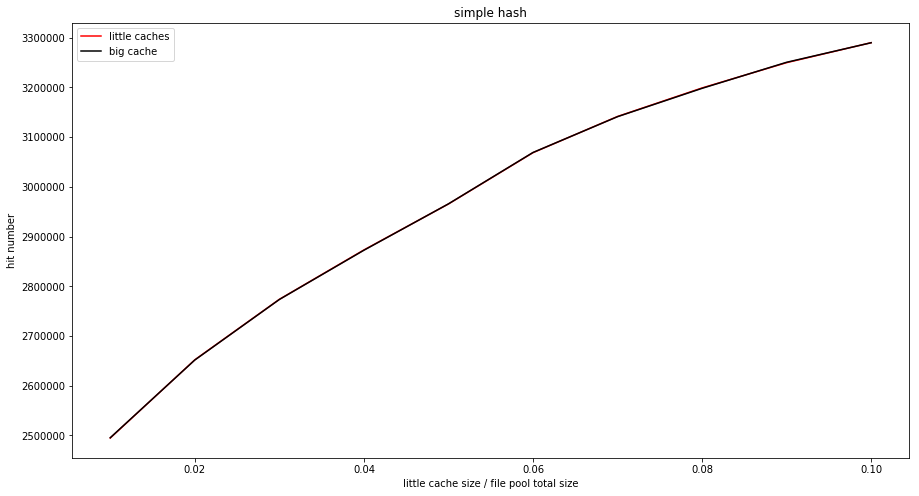

In [11]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array, small_server_hit_number, color='red', label='little caches')
plt.plot(cache_size_array, big_server_hit_number, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("simple hash")
plt.legend()

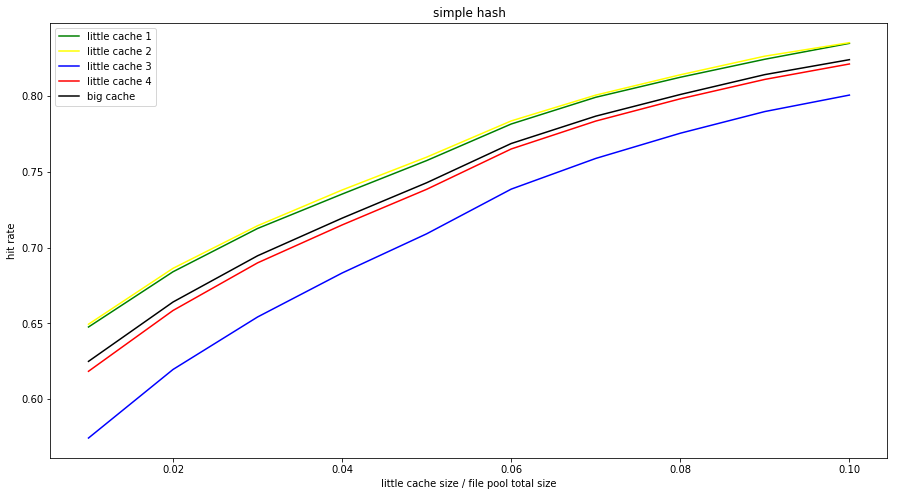

In [12]:
colors = ['green', 'yellow', 'blue', 'red']
plt.figure(figsize=(15,8))
for i in range(CACHE_NUMBER):
    plt.plot(cache_size_array, [j[i] for j in small_server_hit_rate], color=colors[i], label='little cache ' + str(i + 1))
plt.plot(cache_size_array, big_server_hit_rate, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("simple hash")
plt.legend()

In [13]:
small_server_hit_rate_ = []
small_server_hit_number_ = []
big_server_hit_rate_ = []
big_server_hit_number_ = []

cache_size_array_ = []
for cache_size in range(total_size // 100, total_size // 10, total_size // 100):
    cache_size_array_.append(cache_size / total_size)
    hash_dispatcher = Dispatcher(FILE_NUM, cache_size, CACHE_NUMBER, False)
    for fid, size in make_requests():
        hash_dispatcher.handle_requests(fid, size)
    small_server_hit_rate_.append([i.hit_rate() for i in hash_dispatcher.small_caches])
    small_server_hit_number_.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))
    big_server_hit_rate_.append(hash_dispatcher.big_cache.hit_rate())
    big_server_hit_number_.append(hash_dispatcher.big_cache.hit_count)

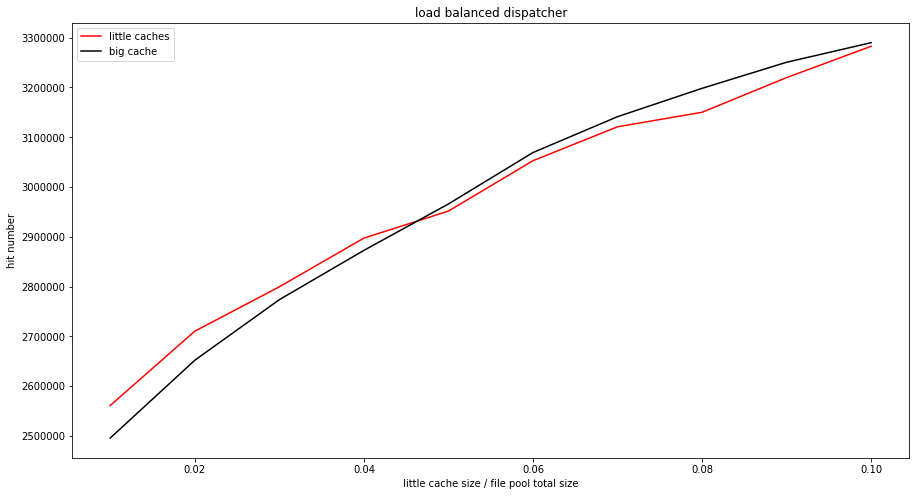

In [14]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array_, small_server_hit_number_, color='red', label='little caches')
plt.plot(cache_size_array_, big_server_hit_number_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("load balanced dispatcher")
plt.legend()

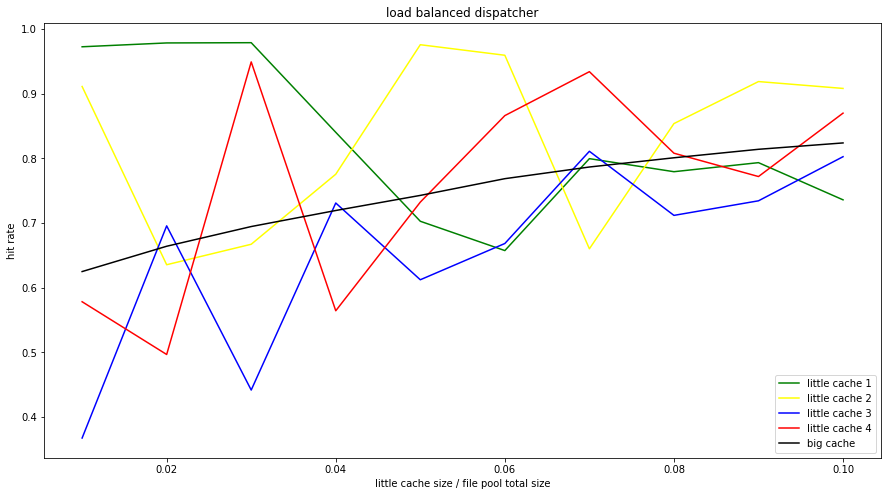

In [15]:
colors = ['green', 'yellow', 'blue', 'red']
plt.figure(figsize=(15,8))
for i in range(CACHE_NUMBER):
    plt.plot(cache_size_array_, [j[i] for j in small_server_hit_rate_], color=colors[i], label='little cache ' + str(i + 1))
plt.plot(cache_size_array_, big_server_hit_rate_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("load balanced dispatcher")
plt.legend()

In [16]:
x = df['Offset'].value_counts().values

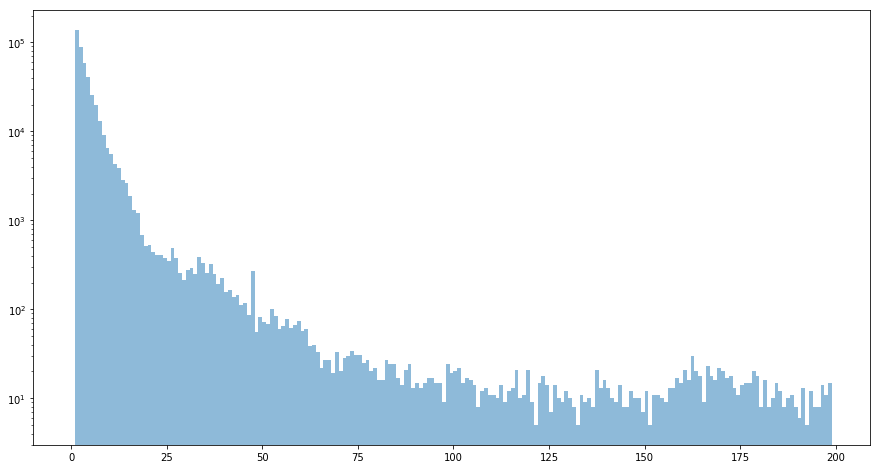

In [29]:
plt.figure(figsize=(15,8))
bins = np.arange(0, 200, 1)
#plt.hist(x[2:], bins, alpha=0.5)
plt.hist(x[2:], bins, alpha=0.5, log = True)
#plt.xlim(0, 1000)
#plt.yscale('log')
plt.legend()

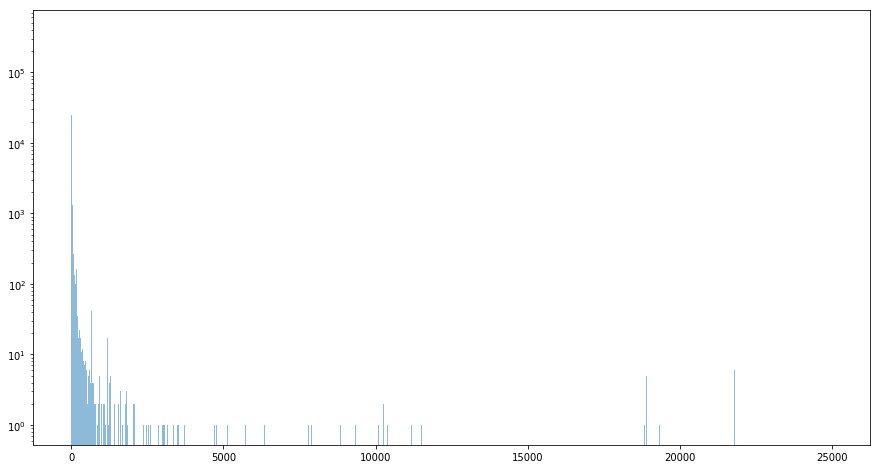

In [30]:
plt.figure(figsize=(15,8))
bins = np.arange(0, 25000, 10)
#plt.hist(x[2:], bins, alpha=0.5)
plt.hist(x[2:], bins, alpha=0.5, log = True)
#plt.xlim(0, 1000)
#plt.yscale('log')
plt.legend()